# Random Forest

## References

https://www.kaggle.com/datasets/alarmanovi/gender-recognition-by-voice-2023

## Import Python Libraries

In [865]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import resample

## Global Variables

In [866]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [867]:
# Source: https://www.kaggle.com/datasets/uciml/glass

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: Mean Frequency (mean_freq): Computed using Fast Fourier Transform (FFT). Represents the average frequency of the audio signal.
# X02: Standard Deviation of Frequency (sd_freq): Calculated using the standard deviation of the spectral centroid. Indicates the spread or variability of the spectral centroid.
# X03: Median Frequency (median_freq): Obtained from the median of the spectral centroid. Represents the middle value of the distribution of spectral centroid frequencies.
# X04: 25th Percentile Frequency (q25_freq): Quantiles of the spectral centroid. Provide information about the distribution of spectral centroid frequencies.
# X05: 75th Percentile Frequency (q75_freq): Quantiles of the spectral centroid. Provide information about the distribution of spectral centroid frequencies.
# X06: Interquartile Range of Frequency (iqr_freq): The range between the 25th and 75th percentiles. Measures the spread of the middle 50% of spectral centroid frequencies.
# X07: Skewness (skewness): Descriptive statistics of the spectral bandwidth. Indicate the shape of the spectral bandwidth distribution.
# X08: Kurtosis (kurtosis_val): Descriptive statistics of the spectral bandwidth. Indicate the shape of the spectral bandwidth distribution.
# X09: Spectral Flatness (spectral_flatness): Represents the flatness of the power spectrum. A measure of how noise-like or tonal the audio is.
# X10: tempogram: a mid-level representation of tempo information, is constructed to characterize tempo variation and local pulse in the audio signal.
# X11: Mode Frequency (mode_freq): Extracted from the tempogram. Represents the mode (most common) frequency in the audio signal.
# X12: Centroid Frequency (centroid_freq): The mean of the spectral centroid. Provides the center of mass of the spectral distribution.
# X13: Peak Frequency (peak_freq): The frequency with the highest amplitude in the spectral centroid. Indicates the dominant frequency in the audio signal.
# X14: mean_fun: Additional Features Related to Fundamental Frequency. Extracted from the root mean square (RMS) values. Provide information about the fundamental frequency.
# X15: min_fun: Additional Features Related to Fundamental Frequency. Extracted from the root mean square (RMS) values. Provide information about the fundamental frequency.
# X16: max_fun: Additional Features Related to Fundamental Frequency. Extracted from the root mean square (RMS) values. Provide information about the fundamental frequency.
# X17: mean_dom: Additional Features Related to Dominant Frequency. Derived from the tempogram. Offer insights into the dominant frequencies and their range.
# X18: min_dom: Additional Features Related to Dominant Frequency. Derived from the tempogram. Offer insights into the dominant frequencies and their range.
# X19: max_dom: Additional Features Related to Dominant Frequency. Derived from the tempogram. Offer insights into the dominant frequencies and their range.
# X20: dom_range: Additional Features Related to Dominant Frequency. Derived from the tempogram. Offer insights into the dominant frequencies and their range.
# X21: Modulation Index (mod_index): Calculated using the YIN algorithm. Indicates the degree of modulation in the audio signal.
#   y: Label (label): Assigned as 'female' or 'Male' for all processed audio files.

In [868]:
# load heart.csv dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/male_female_voice.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,mean_freq,sd_freq,median_freq,q25_freq,q75_freq,iqr_freq,skewness,kurtosis_val,spectral_flatness,tempogram,...,peak_freq,mean_fun,min_fun,max_fun,mean_dom,min_dom,max_dom,fund_freq,mod_index,label
0,0.101925,1258.484673,1.101064,0.911917,2.156636,0.001245,616.124085,-0.001148,0.004659,0.000133,...,166.0,0.000019,5.290000e-13,0.000064,0.132647,-0.0,1.0,205.312043,15.314357,male
1,0.141755,1087.412699,2.279823,1.597941,3.019070,0.001421,303.676155,-0.000125,0.000518,0.000146,...,153.0,0.000054,2.821115e-06,0.000133,0.146389,-0.0,1.0,239.989176,29.892067,male
2,0.086956,772.431710,0.833124,0.655712,1.613551,0.000958,517.743718,-0.000878,0.000444,0.000160,...,124.0,0.000011,3.726945e-07,0.000037,0.160206,-0.0,1.0,172.931651,10.603064,male
3,0.272180,754.611927,1.279489,1.062411,1.512505,0.000450,422.531605,0.000301,0.000230,0.000200,...,582.0,0.000013,3.742320e-06,0.000024,0.199956,-0.0,1.0,212.732706,32.122518,male
4,0.158995,634.740672,1.762929,1.479458,2.106728,0.000627,243.829730,0.000654,0.000110,0.000181,...,83.0,0.000071,1.527331e-05,0.000176,0.180945,-0.0,1.0,236.450792,9.935689,male


In [869]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'label'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [870]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,y
0,0.101925,1258.484673,1.101064,0.911917,2.156636,0.001245,616.124085,-0.001148,0.004659,0.000133,...,166.0,0.000019,5.290000e-13,0.000064,0.132647,-0.0,1.0,205.312043,15.314357,male
1,0.141755,1087.412699,2.279823,1.597941,3.019070,0.001421,303.676155,-0.000125,0.000518,0.000146,...,153.0,0.000054,2.821115e-06,0.000133,0.146389,-0.0,1.0,239.989176,29.892067,male
2,0.086956,772.431710,0.833124,0.655712,1.613551,0.000958,517.743718,-0.000878,0.000444,0.000160,...,124.0,0.000011,3.726945e-07,0.000037,0.160206,-0.0,1.0,172.931651,10.603064,male
3,0.272180,754.611927,1.279489,1.062411,1.512505,0.000450,422.531605,0.000301,0.000230,0.000200,...,582.0,0.000013,3.742320e-06,0.000024,0.199956,-0.0,1.0,212.732706,32.122518,male
4,0.158995,634.740672,1.762929,1.479458,2.106728,0.000627,243.829730,0.000654,0.000110,0.000181,...,83.0,0.000071,1.527331e-05,0.000176,0.180945,-0.0,1.0,236.450792,9.935689,male


In [871]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5993 entries, 0 to 5992
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     5993 non-null   float64
 1   X02     5993 non-null   float64
 2   X03     5993 non-null   float64
 3   X04     5993 non-null   float64
 4   X05     5993 non-null   float64
 5   X06     5993 non-null   float64
 6   X07     5993 non-null   float64
 7   X08     5993 non-null   float64
 8   X09     5993 non-null   float64
 9   X10     5993 non-null   float64
 10  X11     5993 non-null   float64
 11  X12     5993 non-null   float64
 12  X13     5993 non-null   float64
 13  X14     5993 non-null   float64
 14  X15     5993 non-null   float64
 15  X16     5993 non-null   float64
 16  X17     5993 non-null   float64
 17  X18     5993 non-null   float64
 18  X19     5993 non-null   float64
 19  X20     5993 non-null   float64
 20  X21     5993 non-null   float64
 21  y       5993 non-null   object 
dtype

In [872]:
# describe data
df1.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21
count,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,5993.000000,...,5993.000000,5993.000000,5993.000000,5.993000e+03,5993.000000,5993.000000,5.993000e+03,5993.0,5993.000000,5993.000000
mean,0.338481,761.020565,1.399165,1.146501,1.847132,0.000701,381.354844,0.000339,0.000707,0.000158,...,1634.933387,152.165360,0.000062,6.727932e-06,0.000159,0.157960,-1.668613e-19,1.0,253.216351,17.448611
std,0.219415,251.631901,0.356573,0.309548,0.475078,0.000316,84.400591,0.001562,0.001516,0.000028,...,369.815453,152.646278,0.000049,1.235205e-05,0.000108,0.027517,1.291748e-17,0.0,79.849107,14.326283
min,0.000000,118.480187,0.262302,0.195782,0.337625,0.000142,89.836751,-0.001594,0.000004,0.000069,...,304.178220,0.000000,0.000002,0.000000e+00,0.000006,0.068926,-1.000000e-15,1.0,74.446723,1.416494
25%,0.170927,574.123400,1.141308,0.920800,1.505274,0.000476,323.128816,-0.000570,0.000154,0.000139,...,1377.076408,63.000000,0.000030,7.644346e-07,0.000083,0.138638,0.000000e+00,1.0,195.598109,9.460127
50%,0.300113,763.274353,1.361954,1.107176,1.806362,0.000636,379.762545,-0.000079,0.000276,0.000158,...,1615.071173,126.000000,0.000047,2.846138e-06,0.000132,0.157960,0.000000e+00,1.0,243.309068,13.772405
75%,0.487619,940.165535,1.622377,1.330819,2.146770,0.000859,439.368299,0.000792,0.000516,0.000177,...,1880.262710,192.000000,0.000078,7.648991e-06,0.000207,0.176736,0.000000e+00,1.0,297.641142,20.540978
max,3.391885,1608.224040,3.356004,3.032274,4.186068,0.002374,679.505785,0.046115,0.059530,0.000252,...,3549.633359,3243.000000,0.000556,3.046583e-04,0.000775,0.252338,-0.000000e+00,1.0,801.780184,237.742628


In [873]:
# check missing values
df1.isna().sum()

X01    0
X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
y      0
dtype: int64

## Data Cleaning

Not Needed

## Transform Dataset

In [874]:
# response column
y_col = new_y_col
y_col

'y'

In [875]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21'],
      dtype='object')

In [876]:
# get unique y_labels
y_labels = df1.y.unique()
# y_labels = {y_labels[i]: i for i in range(len(y_labels))}
y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{0: 'male', 1: 'female'}

In [877]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,y
0,0.101925,1258.484673,1.101064,0.911917,2.156636,0.001245,616.124085,-0.001148,0.004659,0.000133,...,166.0,0.000019,5.290000e-13,0.000064,0.132647,-0.0,1.0,205.312043,15.314357,male
1,0.141755,1087.412699,2.279823,1.597941,3.019070,0.001421,303.676155,-0.000125,0.000518,0.000146,...,153.0,0.000054,2.821115e-06,0.000133,0.146389,-0.0,1.0,239.989176,29.892067,male
2,0.086956,772.431710,0.833124,0.655712,1.613551,0.000958,517.743718,-0.000878,0.000444,0.000160,...,124.0,0.000011,3.726945e-07,0.000037,0.160206,-0.0,1.0,172.931651,10.603064,male
3,0.272180,754.611927,1.279489,1.062411,1.512505,0.000450,422.531605,0.000301,0.000230,0.000200,...,582.0,0.000013,3.742320e-06,0.000024,0.199956,-0.0,1.0,212.732706,32.122518,male
4,0.158995,634.740672,1.762929,1.479458,2.106728,0.000627,243.829730,0.000654,0.000110,0.000181,...,83.0,0.000071,1.527331e-05,0.000176,0.180945,-0.0,1.0,236.450792,9.935689,male


In [878]:
# check label distribution
temp = list(y_labels.values())
cond1 = df1.y == temp[0]
cond2 = df1.y == temp[1]

n_1 = np.sum(cond1)
print(temp[0])
print(n_1)

n_2 = np.sum(cond2)
print(temp[1])
print(n_2)

# upsample minority label
df_temp = df1.loc[cond2,:]
n_diff = n_1 - n_2
print(n_diff)

df_upsample = resample(
  df_temp,
  replace = True,
  n_samples = n_diff,
  random_state = random_state
)

# update df1
df1 = pd.concat([df1, df_upsample], ignore_index = True)
df1.info()

male
3682
female
2311
1371
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7364 entries, 0 to 7363
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     7364 non-null   float64
 1   X02     7364 non-null   float64
 2   X03     7364 non-null   float64
 3   X04     7364 non-null   float64
 4   X05     7364 non-null   float64
 5   X06     7364 non-null   float64
 6   X07     7364 non-null   float64
 7   X08     7364 non-null   float64
 8   X09     7364 non-null   float64
 9   X10     7364 non-null   float64
 10  X11     7364 non-null   float64
 11  X12     7364 non-null   float64
 12  X13     7364 non-null   float64
 13  X14     7364 non-null   float64
 14  X15     7364 non-null   float64
 15  X16     7364 non-null   float64
 16  X17     7364 non-null   float64
 17  X18     7364 non-null   float64
 18  X19     7364 non-null   float64
 19  X20     7364 non-null   float64
 20  X21     7364 non-null   float64
 21  y       73

In [879]:
# # check label distribution
# temp = list(y_labels.values())
# cond1 = df1.y == temp[0]
# cond2 = df1.y == temp[1]

# n_1 = np.sum(cond1)
# print(temp[0])
# print(n_1)

# n_2 = np.sum(cond2)
# print(temp[1])
# print(n_2)

# # downsample majority label
# df_temp = df1.loc[cond1,:]
# n_diff = n_1 - n_2
# print(n_diff)

# df_upsample = resample(
#   df_temp,
#   replace = False,
#   n_samples = n_diff,
#   random_state = random_state
# )

# # # update df1
# df1 = df1.drop(df_upsample.index)
# df1.info()

In [880]:
# normalize all X_cols
df2 = df1.copy()
# norm = StandardScaler()
# norm = MinMaxScaler()
norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,y
0,-0.640266,1.341706,-0.597762,-0.518914,0.512519,1.612422,2.005114,-0.803225,12.132661,-0.685043,...,0.317215,-0.610846,-0.413363,-0.557784,-0.685043,-0.0,0.0,-0.435770,0.125268,male
1,-0.516843,0.881630,1.835224,1.122881,1.868204,2.082687,-0.661454,-0.063293,0.669730,-0.325986,...,0.216634,0.134862,-0.006148,-0.001888,-0.325986,-0.0,0.0,-0.098304,1.442470,male
2,-0.686652,0.034530,-1.150798,-1.132064,-0.341172,0.847671,1.165493,-0.607554,0.467339,0.035026,...,-0.007737,-0.761202,-0.359566,-0.773814,0.035026,-0.0,0.0,-0.750886,-0.300432,male
3,-0.112691,-0.013394,-0.229488,-0.158752,-0.500008,-0.505845,0.352911,0.244985,-0.125127,1.073647,...,3.535783,-0.721352,0.126824,-0.884736,1.073647,-0.0,0.0,-0.363555,1.644007,male
4,-0.463424,-0.335772,0.768343,0.839327,0.434068,-0.033538,-1.172210,0.500679,-0.457415,0.576917,...,-0.324952,0.486386,1.791269,0.351258,0.576917,-0.0,0.0,-0.132738,-0.360734,male


In [881]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

In [882]:
# melt df2 into a dataframe where cols become stacked as rows
df3 = df2.melt(
  id_vars = y_col,
  value_vars = X_cols,
  var_name = 'X',
  value_name = "X_value"
)
df3.head()

,y,X,X_value
0,male,X01,-0.640266
1,male,X01,-0.516843
2,male,X01,-0.686652
3,male,X01,-0.112691
4,male,X01,-0.463424


## Visualize Dataset

In [883]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (20, 30)

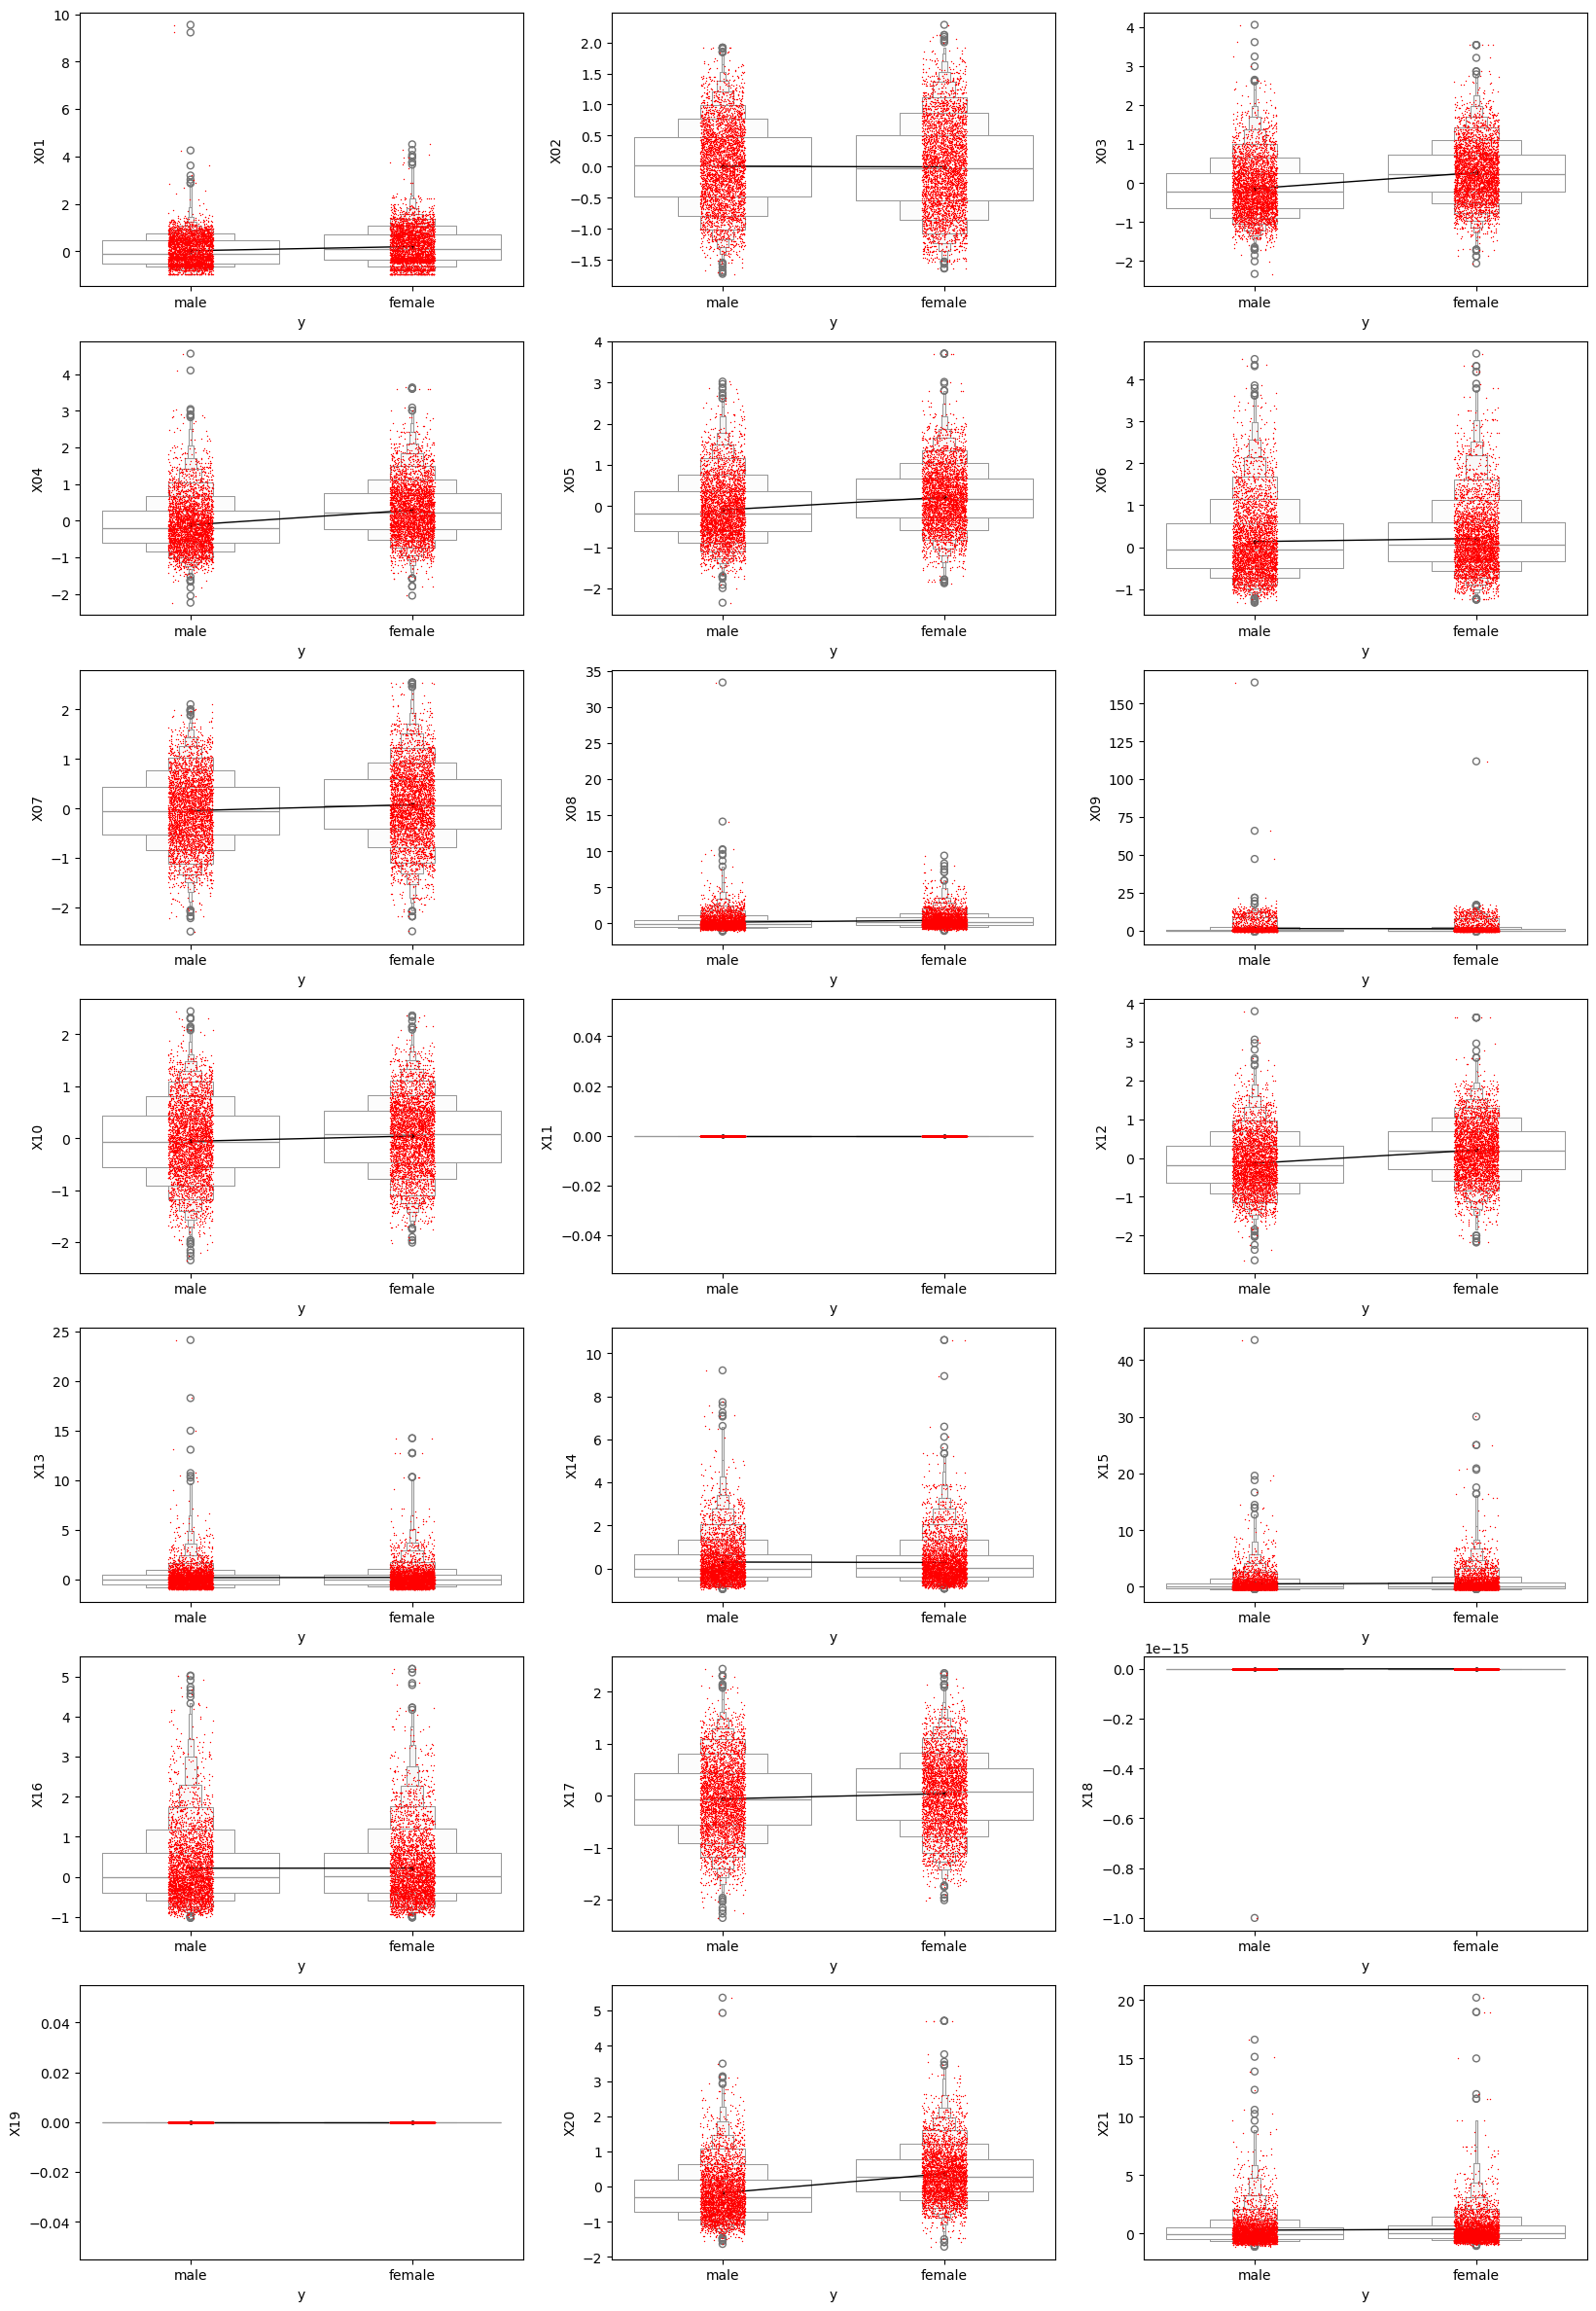

In [884]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Remove Features Having % Similar Values or More

In [885]:
# porportion similar (p)
p = 1
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

1 0


In [886]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [887]:
# fit model
temp = myfit.fit_transform(df2[X_cols])
temp.shape

(7364, 19)

In [888]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X20',
       'X21'], dtype=object)

In [889]:
# update X_cols
X_cols = X_cols_var_threshold
X_cols

array(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X20',
       'X21'], dtype=object)

### Select Features Using Model Selection Methods

In [890]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [891]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 10,
  max_depth = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [892]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [893]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.05322342, 0.05652944, 0.07120433, 0.05734471, 0.0448016 ,
       0.04324479, 0.0988208 , 0.08913198, 0.04074804, 0.03412969,
       0.0441237 , 0.03406546, 0.026742  , 0.03381265, 0.0320632 ,
       0.03507346, 0.        , 0.15749926, 0.04744147])

In [894]:
# threshold feature importance
feature_importance_threshold = np.mean(feature_importance)
# feature_importance_threshold = np.median(feature_importance)
# feature_importance_threshold = np.quantile(feature_importance, q = 0.5)
feature_importance_threshold

0.05263157894736842

In [895]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = feature_importance_threshold
)

In [896]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [897]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X01', 'X02', 'X03', 'X04', 'X07', 'X08', 'X20'], dtype=object)

## Train and Test ML Model

In [898]:
# X_cols to include after feature selection
# X_include = X.columns
X_include = X_cols_rf
print(len(X_include))
print(X_include)

7
['X01' 'X02' 'X03' 'X04' 'X07' 'X08' 'X20']


In [899]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X[X_include], y, 
  stratify = y, shuffle = True, 
  train_size = 0.7, random_state = random_state
)

In [900]:
# initialize Random Forest model
myfit = RandomForestClassifier(
  criterion = 'log_loss',
  # min_samples_split = 10,
  random_state = random_state
)

In [901]:
# fit model
temp = myfit.fit(X_train, y_train)

In [902]:
# get predictions on test data
y_hat = myfit.predict(X_test)

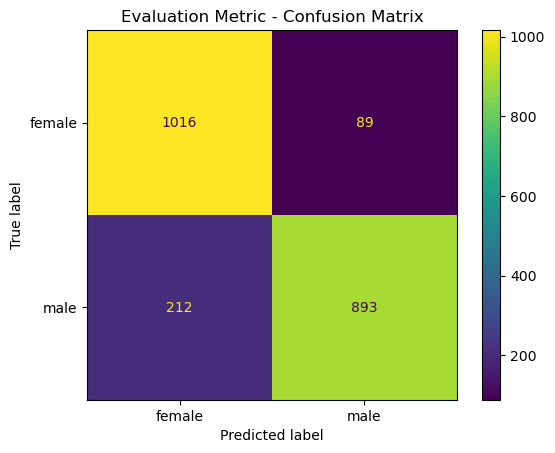

In [903]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [904]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

      female       0.83      0.92      0.87      1105
        male       0.91      0.81      0.86      1105

    accuracy                           0.86      2210
   macro avg       0.87      0.86      0.86      2210
weighted avg       0.87      0.86      0.86      2210

